In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
# from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Activation, LeakyReLU, Dropout, BatchNormalization, MaxPooling2D, Lambda
from keras.models import Model
from sklearn.metrics import mean_squared_error as mse
from progressbar import ProgressBar
from image_process import ImageProcess
import const, cv2
from drive_data import DriveData
from config import Config

import matplotlib.pyplot as plt
import sys
sys.setrecursionlimit(10**7)
tf.compat.v1.experimental.output_all_intermediates(True)
tf.compat.v1.disable_eager_execution()

               Configuration Settings
Neural Net:     	fusion_kdh_jaerock3
Data Collection:	fusion_kdh_jaerock3
Run Neural:     	fusion_kdh_jaerock3




In [2]:
config = Config.neural_net
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
gpu_config = tf.compat.v1.ConfigProto()
gpu_config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=gpu_config)
tf.compat.v1.keras.backend.set_session(sess)
batch_size = 1

In [3]:
"""
## Encoder
"""

"""
## Create a sampling layer
"""
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

encoder_inputs_img = tf.keras.Input(batch_shape=(batch_size*1, 1, 160, 160, 3))
encoder_inputs_str = tf.keras.Input(batch_shape=(batch_size*1, 1, 1))
encoder_inputs_vel = tf.keras.Input(batch_shape=(batch_size*1, 1, 1))
encoder_inputs_time = tf.keras.Input(batch_shape=(batch_size*1, 1, 1))
x = layers.TimeDistributed(layers.Conv2D(24, (5, 5), padding='same', name='conv2d_1'))(encoder_inputs_img)
x = layers.TimeDistributed(layers.BatchNormalization())(x)
x = layers.TimeDistributed(layers.Activation('elu'))(x)
x = layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2), name='pool2d_1'))(x)
x = layers.TimeDistributed(layers.Conv2D(36, (5, 5), padding='same', name='conv2d_2'))(x)
x = layers.TimeDistributed(layers.BatchNormalization())(x)
x = layers.TimeDistributed(layers.Activation('elu'))(x)
x = layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2), name='pool2d_2'))(x)
x = layers.TimeDistributed(layers.Conv2D(48, (5, 5), padding='same', name='conv2d_3'))(x)
x = layers.TimeDistributed(layers.BatchNormalization())(x)
x = layers.TimeDistributed(layers.Activation('elu'))(x)
x = layers.TimeDistributed(layers.Conv2D(64, (3, 3), padding='same', name='conv2d_4'))(x)
x = layers.TimeDistributed(layers.BatchNormalization())(x)
x = layers.TimeDistributed(layers.Activation('elu'))(x)
x = layers.TimeDistributed(layers.Conv2D(64, (3, 3), padding='same', name='conv2d_5'))(x)
x = layers.TimeDistributed(layers.BatchNormalization())(x)
x = layers.TimeDistributed(layers.Activation('elu'))(x)
latent = layers.TimeDistributed(layers.Flatten())(x)
latent = layers.TimeDistributed(layers.Dense(500))(latent)
latent = layers.TimeDistributed(layers.LayerNormalization())(latent)
latent = layers.TimeDistributed(layers.Activation('tanh'))(latent)
fc_s1  = layers.TimeDistributed(layers.Dense(100))(encoder_inputs_str)
fc_s1  = layers.TimeDistributed(layers.BatchNormalization())(fc_s1)
fc_s1  = layers.TimeDistributed(layers.Activation('elu'))(fc_s1)
fc_s2  = layers.TimeDistributed(layers.Dense(50))(fc_s1)
fc_s2  = layers.TimeDistributed(layers.BatchNormalization())(fc_s2)
fc_s2  = layers.TimeDistributed(layers.Activation('elu'))(fc_s2)
fc_v1  = layers.TimeDistributed(layers.Dense(100))(encoder_inputs_vel)
fc_v1  = layers.TimeDistributed(layers.BatchNormalization())(fc_v1)
fc_v1  = layers.TimeDistributed(layers.Activation('elu'))(fc_v1)
fc_v2  = layers.TimeDistributed(layers.Dense(50))(fc_v1)
fc_v2  = layers.TimeDistributed(layers.BatchNormalization())(fc_v2)
fc_v2  = layers.TimeDistributed(layers.Activation('elu'))(fc_v2)
fc_t1  = layers.TimeDistributed(layers.Dense(100))(encoder_inputs_time)
fc_t1  = layers.TimeDistributed(layers.BatchNormalization())(fc_t1)
fc_t1  = layers.TimeDistributed(layers.Activation('elu'))(fc_t1)
fc_t2  = layers.TimeDistributed(layers.Dense(50))(fc_t1)
fc_t2  = layers.TimeDistributed(layers.BatchNormalization())(fc_t2)
fc_t2  = layers.TimeDistributed(layers.Activation('elu'))(fc_t2)
conc_1 = layers.concatenate([latent, fc_s2, fc_v2, fc_t2])
bilstm = layers.Bidirectional(layers.LSTM(500, batch_size=batch_size*1, stateful=True))(conc_1)
# bilstm = layers.Bidirectional(layers.LSTM(500, input_shape=(1000, 1), batch_size=10, stateful=True))(conc_1)
fc_1   = layers.Dense(500)(bilstm)
fc_1   = layers.Activation('elu')(fc_1)
fc_2   = layers.Dense(100)(fc_1)
x   = layers.Activation('elu')(fc_2)
z_mean = layers.Dense(50, name="z_mean")(x)
z_log_var = layers.Dense(50, name="z_log_var")(x)
encoder_output = Sampling()([z_mean, z_log_var])
encoder = tf.keras.Model([ encoder_inputs_img, encoder_inputs_str,
                        encoder_inputs_vel, encoder_inputs_time], 
                        [z_mean, z_log_var, encoder_output], 
                        name="encoder")

"""
## Decoder
"""
latent_inputs = tf.keras.Input(shape=(50,))
x = layers.Dense(40 * 40 * 64, activation="elu")(latent_inputs)
x = layers.Reshape((40, 40, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="elu",  padding="same")(x)
x = layers.Conv2DTranspose(48, 3, activation="elu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(36, 3, activation="elu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")

"""
## VAE
"""
model_input = [ encoder_inputs_img, encoder_inputs_str,
                        encoder_inputs_vel, encoder_inputs_time]
model_output = decoder(encoder_output)

Fwd=Model(model_input, model_output)
Fwd.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(1, 1, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (1, 1, 160, 160, 24) 1824        input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (1, 1, 160, 160, 24) 96          time_distributed[0][0]           
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (1, 1, 160, 160, 24) 0           time_distributed_1[0][0]         
______________________

In [13]:
# Load weight

load_fwd_h5 = '/home2/kdh/vae/new_dataset/vqvae2/vae_b64_mse_load_ckpt.289-831.5888.h5'
Fwd.load_weights(load_fwd_h5)


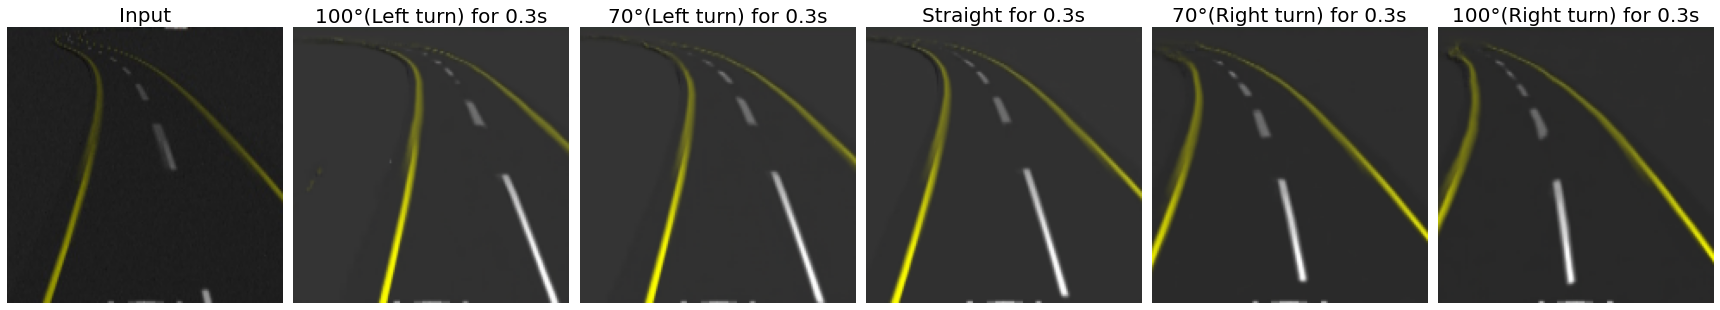

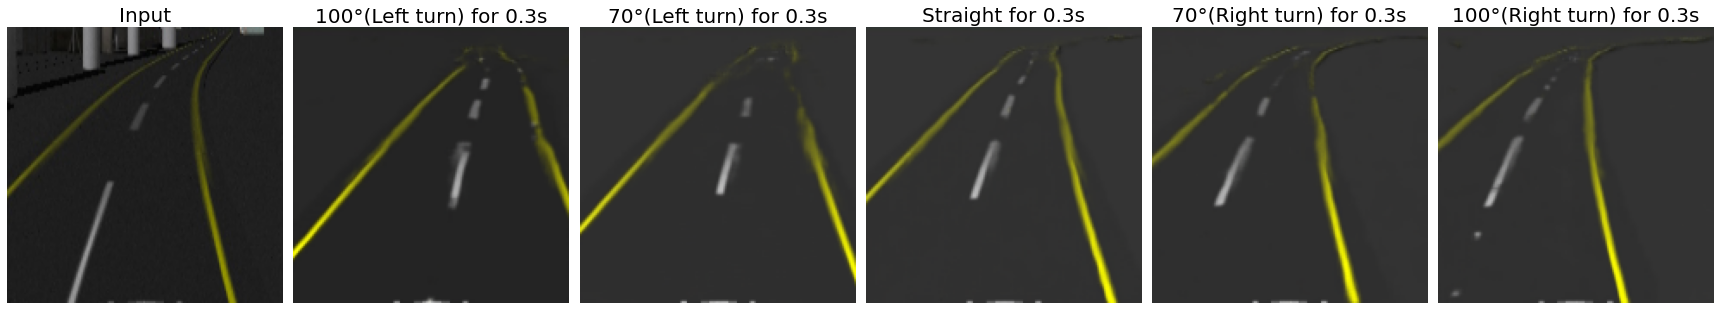

In [60]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import array_to_img
def plot_latent_space(model, pimage, n=50, figsize=15):
    image = pimage[Config.data_collection['image_crop_y1']:Config.data_collection['image_crop_y2'],
                Config.data_collection['image_crop_x1']:Config.data_collection['image_crop_x2']]
    image = cv2.resize(image, 
                        (config['input_image_width'],
                        config['input_image_height']))
    resize = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.array(image).astype("float32")/255.0
    image = np.expand_dims(image, axis=(0,1))
    
    # set input variable
    X_tvel = np.array([[[14.5]]])
    X_ttime = np.array([[0.33]])

    X_tstr1 = np.array([[0.243]])
    X_tstr2 = np.array([[0.142]])
    X_tstr0 = np.array([[0.0]])
    X_tstr3 = np.array([[-0.15]])
    X_tstr4 = np.array([[-0.25]])

    X_tvel = X_tvel.reshape(-1, 1, 1)
    X_ttime = X_ttime.reshape(-1, 1, 1)
    X_tstr1 = X_tstr1.reshape(-1, 1, 1)
    X_tstr2 = X_tstr2.reshape(-1, 1, 1)
    X_tstr0 = X_tstr0.reshape(-1, 1, 1)
    X_tstr3 = X_tstr3.reshape(-1, 1, 1)
    X_tstr4 = X_tstr4.reshape(-1, 1, 1)
    X_train0 = [image, X_tstr0, X_tvel, X_ttime]
    X_train1 = [image, X_tstr1, X_tvel, X_ttime]
    X_train2 = [image, X_tstr2, X_tvel, X_ttime]
    X_train3 = [image, X_tstr3, X_tvel, X_ttime]
    X_train4 = [image, X_tstr4, X_tvel, X_ttime]


    fig, axes = plt.subplots(1, 6, figsize=(24, 6))
    axes[0].imshow(resize, cmap='viridis')
    axes[0].axis('off')  # 축 정보 끄기
    axes[0].set_title('Input', fontsize=20)

    x_encoded = model.predict(X_train1)*255.0
    x_encoded_out = np.squeeze(x_encoded,axis=0)
    pred_image = array_to_img(x_encoded_out)
    pred_image = np.array(pred_image)
    pred_image = cv2.cvtColor(pred_image, cv2.COLOR_BGR2RGB)
    axes[1].imshow(pred_image, cmap='viridis')
    axes[1].axis('off')  # 축 정보 끄기
    axes[1].set_title('100°(Left turn) for 0.3s', fontsize=20)

    x_encoded = model.predict(X_train2)*255.0
    x_encoded_out = np.squeeze(x_encoded,axis=0)
    pred_image = array_to_img(x_encoded_out)
    pred_image = np.array(pred_image)
    pred_image = cv2.cvtColor(pred_image, cv2.COLOR_BGR2RGB)
    axes[2].imshow(pred_image, cmap='viridis')
    axes[2].set_title('70°(Left turn) for 0.3s', fontsize=20)
    axes[2].axis('off')  # 축 정보 끄기

    x_encoded = model.predict(X_train0)*255.0
    x_encoded_out = np.squeeze(x_encoded,axis=0)
    pred_image = array_to_img(x_encoded_out)
    pred_image = np.array(pred_image)
    pred_image = cv2.cvtColor(pred_image, cv2.COLOR_BGR2RGB)
    axes[3].imshow(pred_image, cmap='viridis')
    axes[3].axis('off')  # 축 정보 끄기
    axes[3].set_title('Straight for 0.3s', fontsize=20)
    
    x_encoded = model.predict(X_train3)*255.0
    x_encoded_out = np.squeeze(x_encoded,axis=0)
    pred_image = array_to_img(x_encoded_out)
    pred_image = np.array(pred_image)
    pred_image = cv2.cvtColor(pred_image, cv2.COLOR_BGR2RGB)
    axes[4].imshow(pred_image, cmap='viridis')
    axes[4].axis('off')  # 축 정보 끄기
    axes[4].set_title('70°(Right turn) for 0.3s', fontsize=20)

    x_encoded = model.predict(X_train4)*255.0
    x_encoded_out = np.squeeze(x_encoded,axis=0)
    pred_image = array_to_img(x_encoded_out)
    pred_image = np.array(pred_image)
    pred_image = cv2.cvtColor(pred_image, cv2.COLOR_BGR2RGB)
    axes[5].imshow(pred_image, cmap='viridis')
    axes[5].axis('off')  # 축 정보 끄기
    axes[5].set_title('100°(Right turn) for 0.3s', fontsize=20)

    plt.tight_layout()
    plt.show()

test_img = cv2.imread('/home2/kdh/vae/2022-12-08-14-25-28/2022-12-08-14-33-35-004744.jpg') #output3
plot_latent_space(Fwd, test_img)
test_img = cv2.imread('/home2/kdh/vae/2022-12-08-14-25-30/2022-12-08-14-27-25-312858.jpg') #output3
plot_latent_space(Fwd, test_img)

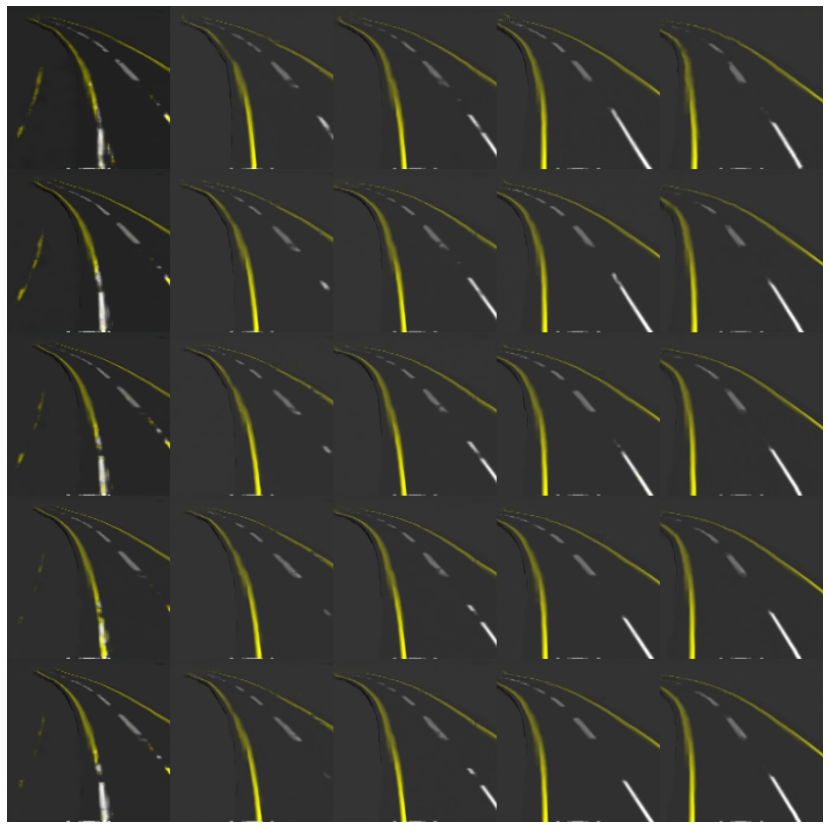

In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import array_to_img

def plot_latent_space(model, image, n=7, figsize=15):
    # Crop and preprocess the image
    image = image[Config.data_collection['image_crop_y1']:Config.data_collection['image_crop_y2'],
                Config.data_collection['image_crop_x1']:Config.data_collection['image_crop_x2']]
    image = cv2.resize(image, 
                        (config['input_image_width'],
                        config['input_image_height']))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.array(image).astype("float32")/255.0

    image = np.expand_dims(image, axis=(0,1))
    # Define steering angles and velocities
    steering_angles = np.linspace(0.2, -0.2, n)  # 0.2 to -0.2 for n values
    times = np.linspace(0.1, 0.6, n)  # 0.1 to 0.6 for n values
    velocity = np.array([[14.8]])  # Fixed velocity

    # Initialize the large image
    digit_size = config['input_image_height']  # assuming square images
    figure = np.zeros((digit_size * n, digit_size * n, 3))

    # Loop over the grid and generate images
    for i, time in enumerate(times):
        for j, str_angle in enumerate(steering_angles):
            # Create input for the model
            X_ttime = np.array([[[time]]]).reshape(-1, 1, 1)
            X_tstr = np.array([[[str_angle]]]).reshape(-1, 1, 1)
            X_tvel = velocity.reshape(-1, 1, 1)
            X_train = [image, X_tstr, X_tvel, X_ttime]

            # Predict the output image
            x_encoded = model.predict(X_train)*255.0
            x_encoded_out = np.squeeze(x_encoded, axis=0)
            pred_image = array_to_img(x_encoded_out)
            pred_image = np.array(pred_image)
            pred_image = cv2.cvtColor(pred_image, cv2.COLOR_BGR2RGB)

            # Place the image in the large image
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = pred_image

    # Plot the large image
    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure.astype('uint8'))
    plt.axis('off')
    plt.show()

# Example usage
# test_img_path = '/home2/kdh/vae/new_dataset/2023-08-22-17-26-01/2023-08-22-15-14-58-165675.jpg'  # Replace with the path to your image
test_img_path = '/home2/kdh/vae/new_dataset/2023-08-22-17-26-01/2023-08-21-16-01-15-541233.jpg'  # Replace with the path to your image
test_img = cv2.imread(test_img_path)
plot_latent_space(Fwd, test_img, n=5)
